In [1]:
import sys
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_HVC = 600, 150, 15

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
aud_real = dict(np.load('learned_song_responses.npz')) # (n_songs, NE, T)
for k in ('ctrl', 'pert'):
    aud_real[k] = (aud_real[k] - aud_real[k].mean()) \
                      / aud_real[k].std()
    aud_real[k] = aud_real[k] * 3 + 1

In [5]:
T_post = 100
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [6]:
aud_idx = rng.choice(np.arange(aud_real['ctrl'].shape[0]), size=N_rend)
aud = np.zeros((T, NE))
for i in range(N_rend):
    t0 = T_burn+i*T_rend
    aud[t0:t0+T_song] = aud_real['ctrl'][aud_idx[i]].T

In [7]:
_ = np.arange(N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, (_+1)*T_rend+T_burn, num=N_HVC, endpoint=False)
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
save_W_ts = np.round(burst_ts[-1]).astype(int)

In [8]:
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
# for i in range(rH.shape[1]):
#     plt.plot(rH[:T_burn+T_rend,i], c='k', alpha=0.1+0.9*i/rH.shape[1])

In [9]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.3
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [10]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [11]:
r_rest = 1 # target rate when phi(0)
rmax, s = 40, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [12]:
w0_mean = 1/N_HVC
w_inh, wI = w0_mean, 0.0
tauE, tauI, dt = 40, 10, 1

netFF = WCNet(NE, N_HVC, w0_mean, phi, tauE, w_inh=w_inh)
netEI = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
              JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI, w0_std=1e-3)

Not a recurrent model and rI will not be calculated.


In [13]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [14]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = netFF.sim(rE0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
              lr=-5e-2, w0_mean=w0_mean, tauW=1e5)
Ws_FF = _[2]
_ = netEI.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
              lr=-8e-2, w0_mean=w0_mean, tauW=1e5)
Ws_EI = _[2]

100%|███████████████████████████████████| 35359/35359 [00:16<00:00, 2133.54it/s]


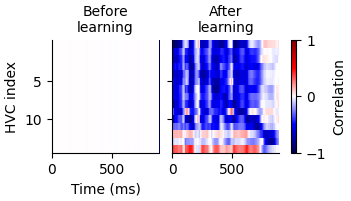

In [15]:
W_syl_corrs = [correlation(_.T, aud_real['ctrl'].mean(axis=0).T, dim=2) for _ in Ws_FF]
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(3.5, 2))
for i, j in enumerate((0, -1)):
    im = ax[i].imshow(W_syl_corrs[j], aspect='auto', interpolation='none', 
                      vmin=-1, vmax=1, cmap='seismic')
ax[0].set_title('Before\nlearning')
ax[1].set_title('After\nlearning')
ax[0].set(ylabel='HVC index', yticks=[5, 10], xlabel='Time (ms)')
cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[-1, 0, 1])

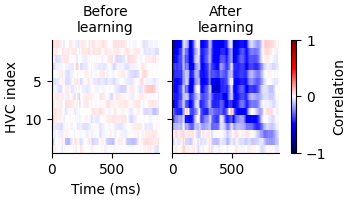

In [16]:
W_syl_corrs = [correlation(_.T, aud_real['ctrl'].mean(axis=0).T, dim=2) for _ in Ws_EI]
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(3.5, 2))
for i, j in enumerate((0, -1)):
    im = ax[i].imshow(W_syl_corrs[j], aspect='auto', interpolation='none', 
                      vmin=-1, vmax=1, cmap='seismic')
ax[0].set_title('Before\nlearning')
ax[1].set_title('After\nlearning')
ax[0].set(ylabel='HVC index', yticks=[5, 10], xlabel='Time (ms)')
cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[-1, 0, 1])

In [17]:
w0_mean, w0_std, cW = 2/N_HVC, 0/N_HVC, 0.05
w_inh, wI = w0_mean*cW, 0.0
tauE, tauI, dt = 40, 10, 1

netEIrec = EINetRecPlasticity(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                              w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)

In [18]:
from numba import njit, void, f8, i4
@njit(void(f8[:], f8[:], f8[:], i4[:], i4[:]))
def outer(out, post, pre, indptr, indices):
    for i in range(len(pre)):
        # range in .data for the i-th col
        p, q = indptr[i], indptr[i+1] 
        out[p:q] = (post[indices[p:q]] - 1) * pre[i]

def bilin_hebb(net, aiv_post, aiv_pre, hvc, lr, J0_mean, tauW):
    # lr < 0, anti-Hebbian
    #### Comment off to enable HVC->E plasticity as well ####
    # if issparse(net.W):
    #     aux = np.zeros(net.W.data.shape)
    #     outer(aux, aiv_post, hvc, net.W.indptr, net.W.indices)
    #     dW = lr * aux - (net.W.data - net.w0_mean)
    #     net.W.data = np.clip(net.W.data + dW / tauW, a_min=0, a_max=None)
    # else:
    #     aux = (aiv_post[:,None] - 1) * hvc[:,None]
    #     dW = lr * (aiv_post[:,None] - 1) * hvc[:,None] - (net.W - net.w0_mean)
    #     net.W = np.clip(net.W + dW / tauW, a_min=1e-10, a_max=None)
    ####
    if issparse(net.JEE):
        aux = np.zeros(net.JEE.data.shape)
        outer(aux, aiv_post, aiv_pre, net.JEE.indptr, net.JEE.indices)
        dW = lr * aux - (net.JEE.data - J0_mean)
        net.JEE.data = np.clip(net.JEE.data + dW / tauW, a_min=1e-10, a_max=None)
    else:
        aux = (aiv_post[:,None] - 1) * aiv_pre[None,:]
        dW = lr * aux - (net.JEE - J0_mean)
        net.JEE = np.clip(net.JEE + dW / tauW, a_min=1e-10, a_max=None)

In [19]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = netEIrec.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
                 lr=-4e-1, asyn=10, J0_mean=J0_mean, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _
if issparse(Ws[0]):
    Ws = [_.toarray() for _ in Ws]

100%|███████████████████████████████████| 35359/35359 [00:33<00:00, 1054.27it/s]


In [20]:
J_corrs = [correlation(_.T, aud_real['ctrl'].mean(axis=0).T, dim=2) for _ in Ws]

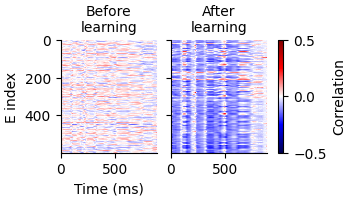

In [21]:
fig, ax = plt.subplots(1, 2, sharey='all', figsize=(3.5, 2))

filt = np.where(netEIrec.W.toarray() != 0)
idx_sig = np.unique(filt[0])
idx_bg = np.array([i for i in range(NE) if i not in idx_sig])
idx = np.hstack([idx_sig, idx_bg])

for i, j in enumerate((0, -1)):
    im = ax[i].imshow(J_corrs[j][idx,:], aspect='auto', interpolation='none', 
                      vmin=-0.5, vmax=0.5, cmap='seismic')
ax[0].set_title('Before\nlearning')
ax[1].set_title('After\nlearning')
ax[0].set(ylabel='E index', xlabel='Time (ms)')
cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[-0.5, 0, 0.5])

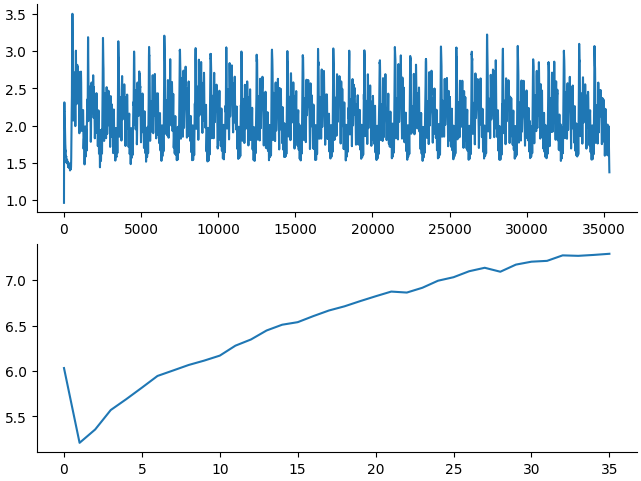

In [22]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws])

## Testing

In [23]:
N_test_rend = 20
T_test = T_burn+T_rend*N_test_rend
_ = np.arange(aud_real['pert'].shape[0])
aud_pert_idx = rng.choice(np.arange(aud_real['pert'].shape[0]), size=N_test_rend)
aud_pert = np.zeros((T_test, NE))
for i in range(N_test_rend):
    aud_pert[T_burn+i*T_rend:T_burn+i*T_rend+T_song] = aud_real['pert'][aud_pert_idx[i]].T

In [24]:
def trial_avg(rs):
    avg = []
    for r in rs:
        r_ = np.zeros((T_rend, r.shape[1]))
        for i in range(N_test_rend):
            r_[:,:] += r[T_burn+i*T_rend:T_burn+(i+1)*T_rend]
        avg.append(r_ / N_test_rend)
    return avg

In [25]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
res = dict(ctrl=[], pert=[], deaf=[])
for k, a in zip(('ctrl', 'pert', 'deaf'), (aud[:T_test], aud_pert, aud_pert*0)):
    res[k].append(trial_avg(netFF.sim(rE0, rH[:T_test], a, [], T_test, dt, 1)[:1]))
    res[k].append(trial_avg(netEI.sim(rE0, rI0, rH[:T_test], a, [], T_test, dt, 1)[:2]))
    res[k].append(trial_avg(netEIrec.sim(rE0, rI0, rH[:T_test], a, [], T_test, dt, 1)[:2]))

100%|███████████████████████████████████| 20419/20419 [00:05<00:00, 3531.12it/s]


[Text(0, 0.5, 'EI network\n(E$\\to$E plasticity)')]

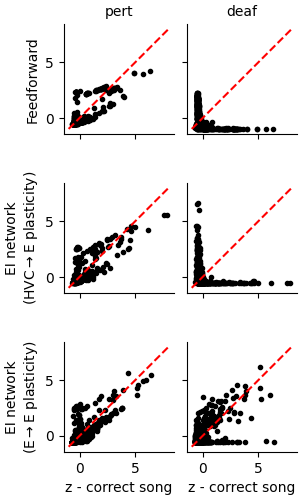

In [33]:
fig, ax = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(3, 5))
for i in range(3):
    z_ctrl = normalize(res['ctrl'][i][0][350:500].mean(axis=0), axis=0)
    for j, k in enumerate(('pert', 'deaf')):
        z_pert = normalize(res[k][i][0][350:500].mean(axis=0), axis=0)
        ax[i,j].plot(z_ctrl, z_pert, 'o', ms=3, c='k')
        ax[i,j].plot([-1, 8], [-1,8], c='r', ls='--')
        ax[i,j].set(aspect=1)
        ax[0,j].set_title(k, fontsize=10)
        ax[-1,j].set(xlabel='z - correct song')
ax[0,0].set(ylabel='Feedforward')
ax[1,0].set(ylabel='EI network\n(HVC$\\to$E plasticity)')
ax[2,0].set(ylabel='EI network\n(E$\\to$E plasticity)')

[Text(0, 0.5, 'Frequency\n(kHz)')]

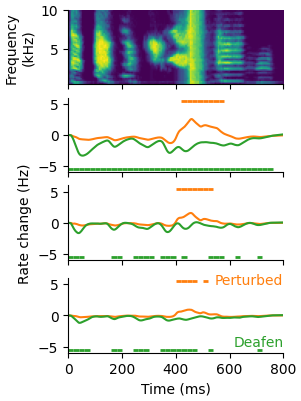

In [29]:
from scipy.stats import ttest_1samp
fig, ax = plt.subplots(4, 1, sharex='all', figsize=(3, 4))
ax[0].imshow(aud_real['specs_pert'][aud_pert_idx].mean(axis=0), cmap='viridis', 
             extent=(0, 800, 0.5, 10), origin='lower', aspect='auto')
ymax, interval = 6, 20
for i in range(3):
    for j, k in enumerate(('pert', 'deaf'), 1):
        c = 'C%d' % j
        diff = (res[k][i][0] - res['ctrl'][i][0])
        ax[i+1].plot(diff.mean(axis=1), c=c)
        ax[i+1].set(xlim=[0, 800], ylim=[-ymax, ymax])

        for t in range(0, T_song, interval):
            p = ttest_1samp(diff[t:t+interval].mean(axis=0), popmean=0,
                            alternative='greater' if k=='pert' else 'less')
            if p.pvalue < 0.001:
                _ = ymax-0.5 if k == 'pert' else -ymax+0.5
                ax[i+1].hlines(_, t, t+interval, lw=2, color=c)
ax[-1].text(800, ymax-1, 'Perturbed', color='C1', ha='right')
ax[-1].text(800, -ymax+1, 'Deafen', color='C2', ha='right')
ax[-1].set(xlabel='Time (ms)')
ax[2].set(ylabel='Rate change (Hz)')
ax[0].set(ylabel='Frequency\n(kHz)')